Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15297048.79it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 435185.75it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3891044.21it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 7520935.16it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Train Epoch: 1 [0/60000 (0%)]	Loss: 546.148132
Train Epoch: 1 [12800/60000 (21%)]	Loss: 193.382019
Train Epoch: 1 [25600/60000 (43%)]	Loss: 185.861389
Train Epoch: 1 [38400/60000 (64%)]	Loss: 157.046158
Train Epoch: 1 [51200/60000 (85%)]	Loss: 146.925003
====> Epoch: 1 Average loss: 178.5103
Train Epoch: 2 [0/60000 (0%)]	Loss: 137.596191
Train Epoch: 2 [12800/60000 (21%)]	Loss: 139.246613
Train Epoch: 2 [25600/60000 (43%)]	Loss: 133.406204
Train Epoch: 2 [38400/60000 (64%)]	Loss: 125.352348
Train Epoch: 2 [51200/60000 (85%)]	Loss: 115.911156
====> Epoch: 2 Average loss: 129.5023
Train Epoch: 3 [0/60000 (0%)]	Loss: 122.740677
Train Epoch: 3 [12800/60000 (21%)]	Loss: 118.101852
Train Epoch: 3 [25600/60000 (43%)]	Loss: 118.707008
Train Epoch: 3 [38400/60000 (64%)]	Loss: 117.157928
Train Epoch: 3 [51200/60000 (85%)]	Loss: 118.844269
====> Epoch: 3 Average loss: 118.7297
Train Epoch: 4 [0/60000 (0%)]	Loss: 112.667465

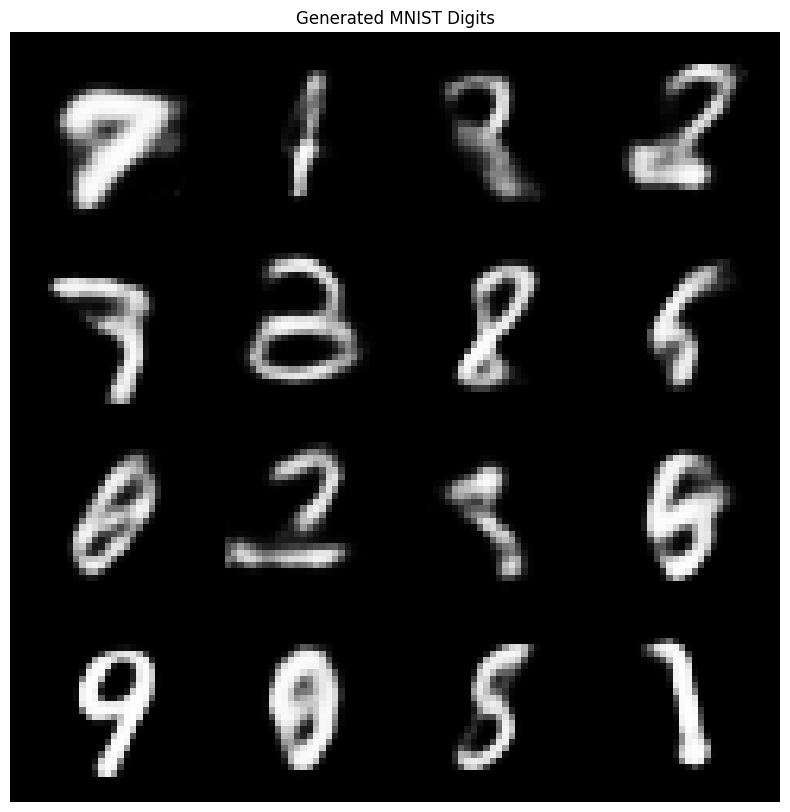

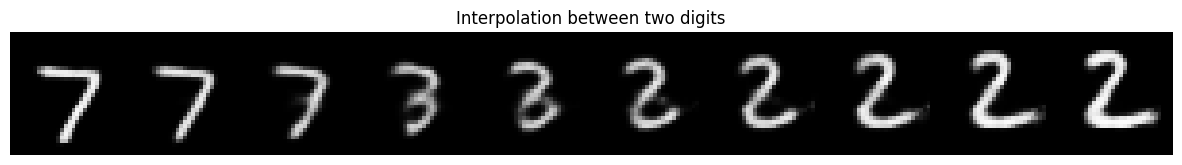

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)

# Define hyperparameters
batch_size = 128
epochs = 50
lr = 1e-3
latent_dim = 20

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the VAE model
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, 200)
        self.fc_mu = nn.Linear(200, latent_dim)
        self.fc_logvar = nn.Linear(200, latent_dim)

        # Decoder
        self.fc3 = nn.Linear(latent_dim, 200)
        self.fc4 = nn.Linear(200, 400)
        self.fc5 = nn.Linear(400, 784)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc3(z))
        h = F.relu(self.fc4(h))
        return torch.sigmoid(self.fc5(h))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Initialize the model and optimizer
model = VAE(latent_dim)
optimizer = optim.Adam(model.parameters(), lr=lr)

# Define the loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Training loop
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')

    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')

# Run the training
for epoch in range(1, epochs + 1):
    train(epoch)

# Generate new digits
def generate_digits(num_digits=16):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_digits, latent_dim)
        sample = model.decode(z)
        return sample.view(-1, 1, 28, 28)

# Generate and display new digits
new_digits = generate_digits()
grid = make_grid(new_digits, nrow=4)
plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0), cmap='gray')
plt.axis('off')
plt.title('Generated MNIST Digits')
plt.show()

# Interpolation in latent space
def interpolate_digits(start_digit, end_digit, steps=10):
    model.eval()
    with torch.no_grad():
        start_z = model.encode(start_digit.view(1, -1))[0]
        end_z = model.encode(end_digit.view(1, -1))[0]

        interpolated_z = torch.zeros(steps, latent_dim)
        for i in range(steps):
            interpolated_z[i] = start_z + (end_z - start_z) * (i / (steps - 1))

        interpolated_digits = model.decode(interpolated_z)
        return interpolated_digits.view(-1, 1, 28, 28)

# Example of interpolation
start_digit = test_dataset[0][0]
end_digit = test_dataset[1][0]
interpolated = interpolate_digits(start_digit, end_digit)

# Display interpolation
grid = make_grid(interpolated, nrow=10)
plt.figure(figsize=(15, 3))
plt.imshow(grid.permute(1, 2, 0), cmap='gray')
plt.axis('off')
plt.title('Interpolation between two digits')
plt.show()

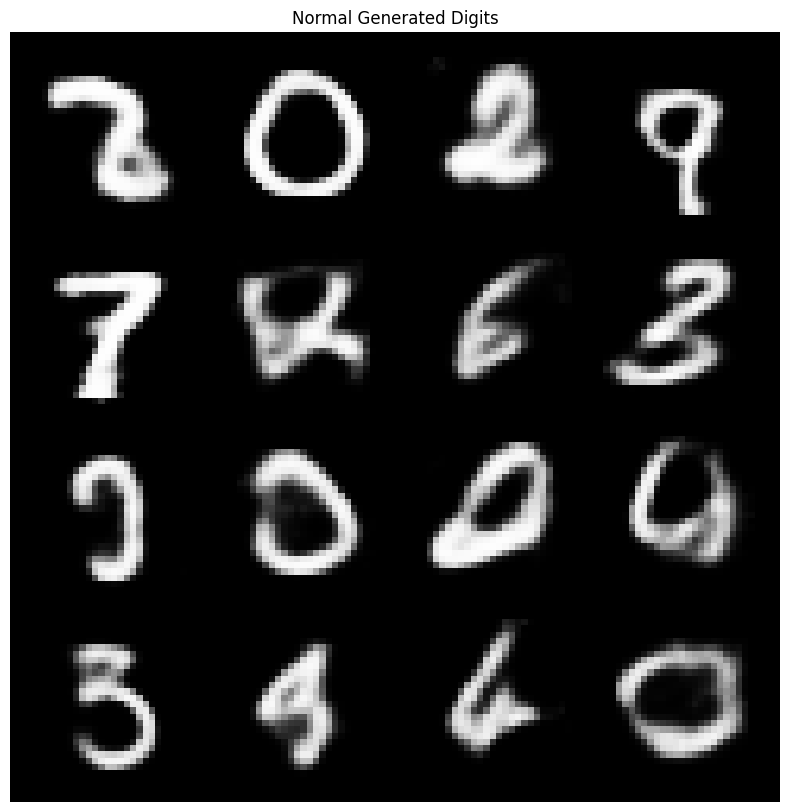

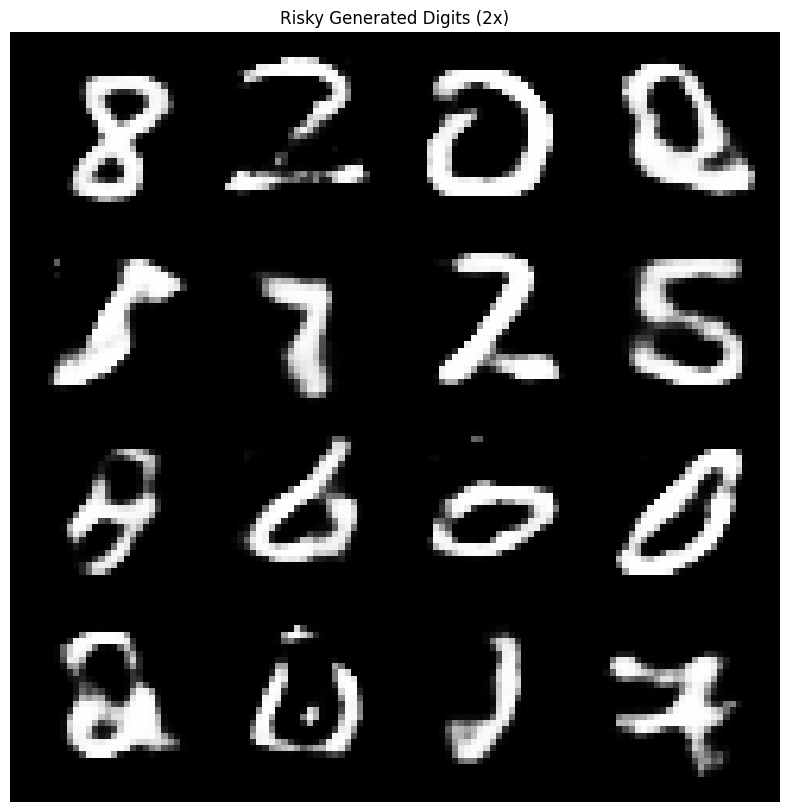

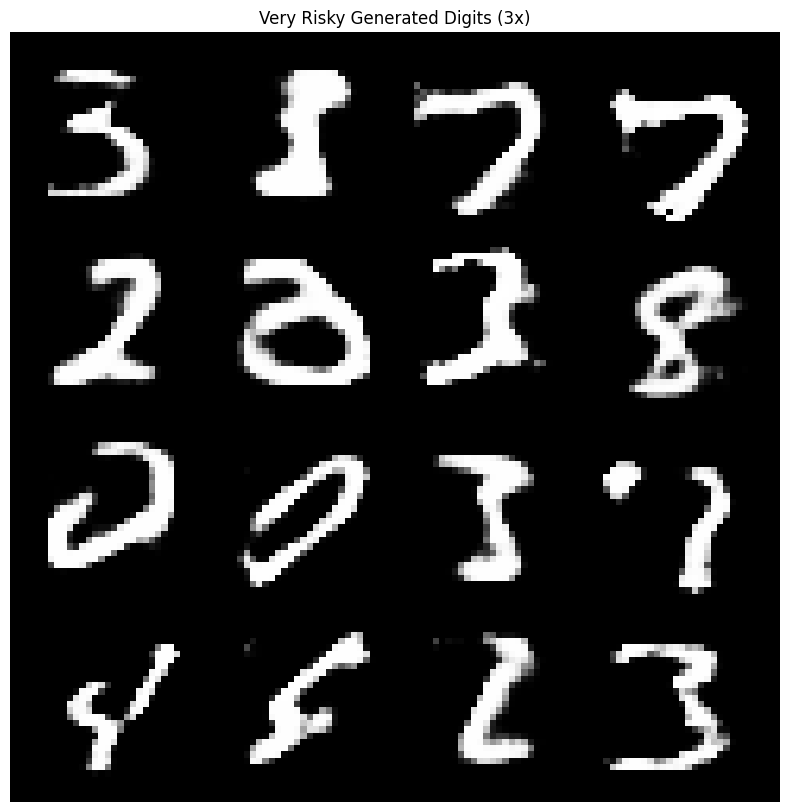

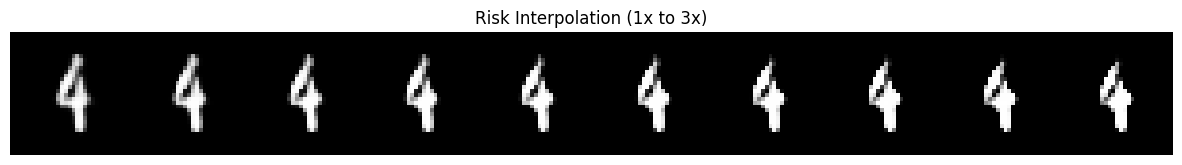

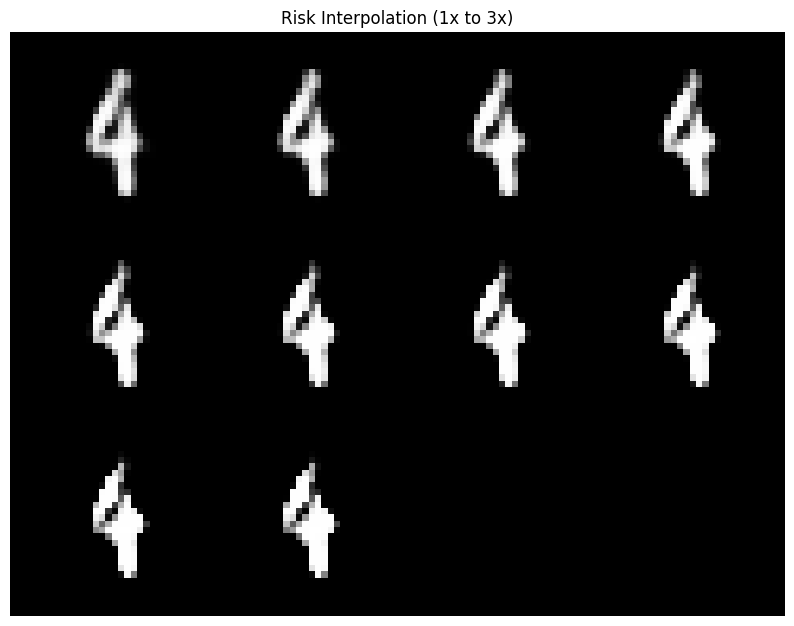

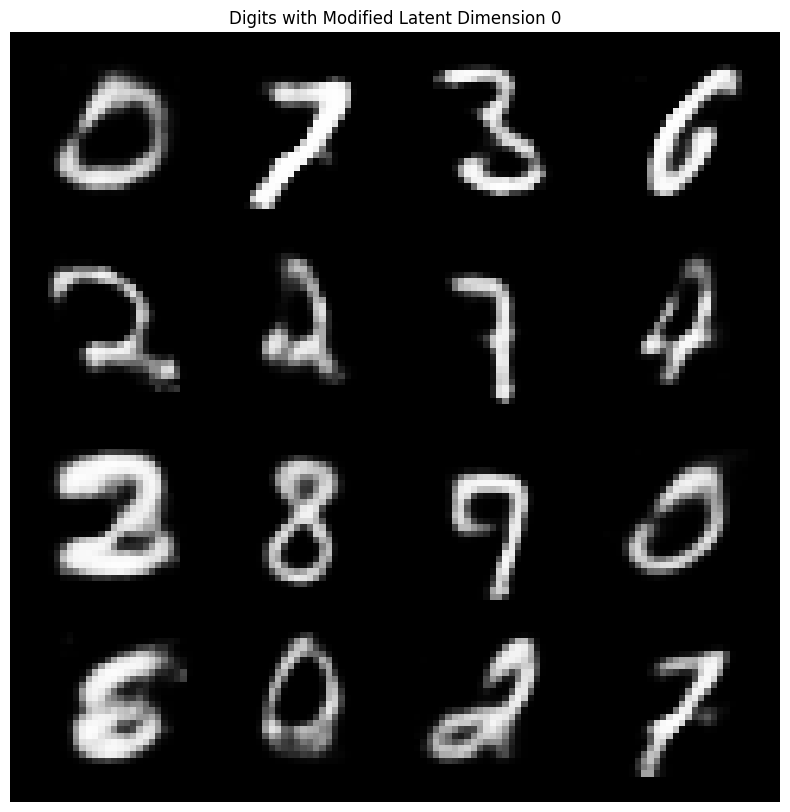

In [5]:
# Function to generate digits with modified latent vectors
def generate_risky_digits(num_digits=16, risk_factor=2.0):
    model.eval()
    with torch.no_grad():
        # Generate random latent vectors from a normal distribution
        z = torch.randn(num_digits, latent_dim)

        # Amplify the latent vectors to make them more "risky"
        z_risky = z * risk_factor

        # Decode the risky latent vectors
        risky_digits = model.decode(z_risky)
        return risky_digits.view(-1, 1, 28, 28)

# Function to visualize the generated digits
def show_digits(digits, title):
    grid = make_grid(digits, nrow=4)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0), cmap='gray')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Generate and show normal digits
normal_digits = generate_digits()
show_digits(normal_digits, "Normal Generated Digits")

# Generate and show risky digits
risky_digits = generate_risky_digits(risk_factor=2.0)
show_digits(risky_digits, "Risky Generated Digits (2x)")

# Generate and show even riskier digits
very_risky_digits = generate_risky_digits(risk_factor=3.0)
show_digits(very_risky_digits, "Very Risky Generated Digits (3x)")

# Function to interpolate between a normal and a risky digit
def interpolate_risk(start_risk=1.0, end_risk=3.0, steps=10):
    model.eval()
    with torch.no_grad():
        z = torch.randn(1, latent_dim)
        interpolated_digits = []
        for i in range(steps):
            risk = start_risk + (end_risk - start_risk) * (i / (steps - 1))
            z_risky = z * risk
            digit = model.decode(z_risky)
            interpolated_digits.append(digit.view(1, 1, 28, 28))
        return torch.cat(interpolated_digits, dim=0)

# Generate risk interpolation
risk_interpolation = interpolate_risk()

# Function to visualize the interpolation
def show_interpolation(digits, title):
    grid = make_grid(digits, nrow=digits.shape[0])
    plt.figure(figsize=(15, 3))
    plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Show risk interpolation
show_interpolation(risk_interpolation, "Risk Interpolation (1x to 3x)")
# Generate and show risk interpolation
show_digits(risk_interpolation, "Risk Interpolation (1x to 3x)")

# Experiment with specific latent dimensions
def modify_latent_dimension(dim, value, num_digits=16):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_digits, latent_dim)
        z[:, dim] = value
        modified_digits = model.decode(z)
        return modified_digits.view(-1, 1, 28, 28)

# Modify a specific latent dimension and show results
modified_digits = modify_latent_dimension(dim=0, value=2.0)
show_digits(modified_digits, "Digits with Modified Latent Dimension 0")